# Jobs, Jobs, Jobs  
  
Employment rules everything around us. Everyone wants to land their dream job. Companies want to hire that one person who will send their performance skyrocketing. For both the employer and the employee, hiring is a critically important process. One way that employers advertise for jobs and communicate what they are looking for is through online job postings. From the employer perspective, it is important to design job ads in a way that help attract the type of candidates that the employee wants to interview. For the job seeker, understanding how to read between the lines of job ads can help in finding the types of opportunities that are good match for the seekers skills and that are the type of place that the seeker would like to work. For my capstone project, I analyzed a set of job ads for data science related positions to attempt to extract insights that might help employers understand the types of applicant that a given ad is likely to attract, and to help job seekers understand which types of ads might be a good fit for them.

In [1]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import permutation_test_score
from gensim.models.phrases import Phrases
from gensim.models.phrases import Phraser
from nltk import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
import matplotlib.pyplot as plt
%matplotlib inline

# A function to extract the city name from the string giving the location
def get_job_city(job_loc):
    job_loc_split = str(job_loc).split(",")
    return(job_loc_split[0])

# A function to extract the state from the string giving the location
def get_job_state(job_loc):
    job_loc_split = str(job_loc).split(",")
    if len(job_loc_split) > 1:
        return(str(job_loc_split[1]).split()[0])
    else:
        return("")
    
# A class to fit a first-order phrase model to a series of job titles
class PhraseBigram(BaseEstimator, TransformerMixin):
    def __init__(self, punct_list, stop_list):
        self.punct_list = punct_list
        self.stop_list = stop_list

    def fit(self, X, y = None):
        # Based on code I saw here: https://www.reddit.com/r/learnmachinelearning/comments/5onknw/python_nlp_need_advice_about_gensim_phrasesphraser/
        # Initialize stemmer
        from gensim.models.phrases import Phrases
        from gensim.models.phrases import Phraser
        from nltk.stem.lancaster import LancasterStemmer
        from nltk import word_tokenize
        lancaster_stemmer = LancasterStemmer()
        # Set lists of characters/words to exclude
        punct_list = self.punct_list
        stop_list = self.stop_list
        # Get sentence stream from titles
        bigram_stream = [[lancaster_stemmer.stem(i.lower()) for i in word_tokenize(sent) if i not in punct_list and i not in stop_list] for sent in list(X)]
        bigram = Phraser(Phrases(bigram_stream, min_count=3, threshold=3, delimiter=b' '))
        self.bigram = bigram
        return(self)
    
    def transform(self, X):
        from gensim.models.phrases import Phrases
        from gensim.models.phrases import Phraser
        from nltk.stem.lancaster import LancasterStemmer
        from nltk import word_tokenize
        lancaster_stemmer = LancasterStemmer()
        punct_list = self.punct_list
        stop_list = self.stop_list
        bigram = self.bigram
        x_list = []
        for j in X:
            doc = [lancaster_stemmer.stem(i) for i in word_tokenize(j) if i not in punct_list and i not in stop_list]
            x_list.append("-".join(bigram[doc]))
            
        return(pd.Series(x_list))

# Function to use as custom tokenizer for results of PhraseBigram.transform
def dash_tokenizer(sent):
    return(sent.split("-"))

#Get the job metadata and job descriptions that were scraped previously from Indeed in a dataframe
job_metadata = pd.read_csv("job_ad_metadata_v2.csv")
job_descriptions = pd.read_csv("job_ad_descriptions_v2.csv")

# How job ads differ between states  
  
I focused on analyzing how job ads differ between states within the US. Understanding regional variation is the types of jobs that companies advertise for can help give insight into the cultures and opportunities in different regions. For employers, this can help with understanding the type of talent pool that the employer can expect to recruit from when recieving applications from that region. For job seekers, this could help with figuring out what regions tend to have the types of jobs the applicant is looking for, as well as what types of skills are likely to be valued in certain regions if the seeker wants to focus on a particular area of the country.  
  
I first wanted to evaluate in a global sense whether job titles vary across states. I focused on titles to begin with because they are often highlly relevant to the people who can potentially use this information (e.g. job seekers might spend a lot of time searching by job title) and because I thought that the natural language features that I could create from the titles had a good chance of representing highly interpretable "archetypes" of jobs. To represent the geographic variation of jobs within the US, I categorized jobs by state. These labels are highly imbalanced, with some states having many jobs, and some having only a few, or even only a single job. As a result, I decided to group the states with very few jobs into their own "Other", category. This has the potential to be interesting, since this category could give insight into possible differences in the cultures and opportunities of the big states with lots of jobs and the smaller states that have fewer jobs.  
  
To evaluate whether job titles provide information about the states where jobs are offered, I fit an L2 regularized logistic regression model using term frequencies in the job titles as features and with the state that the job is in as the target. Logistic regression serves my purposes here because my main aim isn't to predict the state that a job is in, but rather to figure out which terms in the model are associated with the job being in a particular state. Logistic regression naturally lends itself to this task, since the coefficients in the model give a natural representation of how a given term is associated with the label. I deal with the multiclass nature of the state label by fitting multiple one-vs-rest logistic regressions, one for each state and one for the "Other" group. I evaluate this model using 5-fold stratified cross validation. Here is the mean CV accuracy of the model: 

In [2]:
# Get series with the city name by applying get_job_city to each location string
job_cities = job_metadata.job_loc.apply(get_job_city)

# Get series with the state by applying get_job_state to each location string
job_states = job_metadata.job_loc.apply(get_job_state)
job_states_lim = job_states

# Give states with reasonable numbers of jobs their own class, group all other as "Other"
job_states_lim[np.logical_not((job_states == "CA") | (job_states == "MA") | (job_states == "NY") | (job_states == "WA") | (job_states == "TX") | (job_states == "NJ") | (job_states == "VA"))] = "Other"

In [3]:
# Intialize the steps in the model and place in a pipeline. Get CV estimates of performance
title_phrase_model = PhraseBigram([".", "-", "_", "!", "?", "[", "]", "(", ")", "%", "$", "&", ",", "/", ":", "–", " "], ["the", "of", "a", "CA"])
job_title_count_vec = CountVectorizer(max_df = 0.95, min_df = 5, stop_words = 'english', tokenizer = dash_tokenizer)
title_logit_model = LogisticRegression()
title_pipeline = Pipeline([('phrase_model', title_phrase_model), ('count_vec', job_title_count_vec), ("logit_model", title_logit_model)])
np.mean(cross_val_score(title_pipeline, job_metadata.job_title, job_states_lim, cv = StratifiedKFold(5), scoring = "accuracy"))

0.3773672049515614

I chose to measure the performance of this model using accuracy because my aim is to inform rather than to maximize prediction performance on any particular metric, and I believe that using a measure like accuracy can be more intiuitive for readers. One problem that this metric does present is that multiple imbalanced classes can make it difficult to interpret. For example, as accuracy of 0.2 might seem poor for a two-class problem, but maybe not for a 50 class problem. Likewise, an accuracy of 0.8 might seem impressive with two balanced classes, but maybe not for a 0.8:0.2 class distribution. To overcome this, I perform a permutation analysis to generate a distribution of accuracy measures that results when the same model as above is fit, but when the state labels are permuted. This distribution of permutation scores gives a sense of how the model would perform when the association between labels and features is broken by the permutation. As a result, if the observed score generally exceeds the permutation scores, this would indicate that the features contain information about the labels. I plot the a histogram of the permutation scores below, with a line representing the observed score:

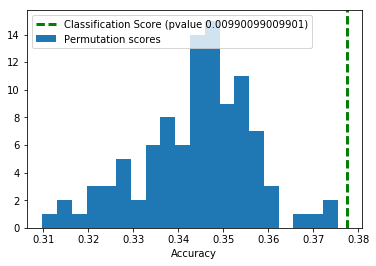

In [4]:
# Permutation test for relevance of fitted model
score, permutation_scores, pvalue = permutation_test_score(title_pipeline, job_metadata.job_title, job_states_lim.values, scoring="accuracy", cv = StratifiedKFold(5), n_permutations = 100)

# Borrow code from http://scikit-learn.org/stable/auto_examples/feature_selection/plot_permutation_test_for_classification.html#sphx-glr-auto-examples-feature-selection-plot-permutation-test-for-classification-py
# Plot a histogram of permutated score as well as the observed score
plt.hist(permutation_scores, 20, label='Permutation scores')
ylim = plt.ylim()
plt.plot(2 * [score], ylim, '--g', linewidth=3,
         label='Classification Score'
         ' (pvalue %s)' % pvalue)

plt.ylim(ylim)
plt.legend()
plt.xlabel('Accuracy')
plt.show()

The observed score is larger than all the scores obtained when permuting the labels, suggesting that the model is informative.

In [5]:
# Fit pipeline on full data set
title_pipe_fit = title_pipeline.fit(job_metadata.job_title, job_states_lim)

# Store components of of the fitted pipeline
title_logit_model = title_pipe_fit.named_steps["logit_model"]
title_phrase_model = title_pipe_fit.named_steps["phrase_model"]
title_count_model = title_pipe_fit.named_steps["count_vec"]

# Transform full dataset and get feature names
title_transform_dense = title_count_model.fit_transform(title_phrase_model.fit_transform(job_metadata.job_title)).todense()
title_transform_dense_names = title_pipeline.get_params()["count_vec"].get_feature_names()
job_title_count_dense = pd.DataFrame(title_transform_dense)
job_title_count_dense.columns = title_transform_dense_names

Having established that the features are informative, I next sought to understand which features are particularly informative. To do this, I took advantage of the fact that the logistic regression model give informative coefficients. The features that I am using are binary indicator features that have tha value 1 if a term is present in a job title, and 0 otherwise. As a result, large positive coefficients indicate that the presence of a term is predictive of a particular state, suggesting that the term is more frequent in titles that come from that state compared to other states. Likewise, large negative coefficients indicate that the term is less frequent in job titles from that state. I start by focusing on which features predict that a job will be in CA vs other states, because CA is the largest non-"Other" category, and because jobs in CA may be representative of a broader "tech industry" cluster of jobs. I take a look at the features with largest positive coefficients:

In [6]:
# Get top features positively associated with the job being in CA
job_title_count_dense.columns[title_logit_model.coef_[0] > 1]

Index(['clin lab', 'machin learn', 'op', 'research assocy', 'softw engin',
       'staff'],
      dtype='object')

and largest negative coefficients:

In [7]:
# Get top features negatively associated with the job being in CA
job_title_count_dense.columns[title_logit_model.coef_[0] < -1]

Index(['assist', 'quantit', 'spec', 'stat', 'techn', 'upstream'], dtype='object')

One thing that jumps out to me is that "machin learn" which is "machine learning" after stemming, is positively associated with CA jobs, while "stat" which is "statistics" or "statistical" after stemming is negatively associated with a job being in CA. To examine this further, I extracted coefficients from the models for all the state categories, and plotted their coefficients for these two variables in a scatter plot:

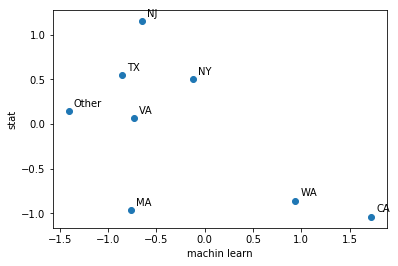

In [8]:
# Visualize logistic model coefficients by state
title_multi_logit_coefs = pd.DataFrame(title_logit_model.coef_)
title_multi_logit_coefs.columns = title_transform_dense_names
fig, ax = plt.subplots()
ax.scatter(title_multi_logit_coefs["machin learn"], title_multi_logit_coefs["stat"])
for i, (x, y) in enumerate(zip(title_multi_logit_coefs["machin learn"], title_multi_logit_coefs["stat"])):
    ax.annotate(list(title_logit_model.classes_)[i], (x, y), xytext=(5, 5), textcoords='offset points')
plt.xlabel("machin learn")
plt.ylabel("stat")
plt.show()

From this plot, WA and CA have large positive coefficents for machine learning, but large negative coefficients for "stat". A focus on machine learning vs a focus on statistics can be indicative of different training, backgrounds, and philosophies about how to approach data science problems. My analysis suggests that some of the west coast states skew towards the machine learning perspective, which I think fits with the idea that this perspective is perhaps more common in the tech industry and start-ups as opposed to more traditional businesses. The other states are further to the left, indicating that they are less likely to have machine learning mentioned in their job titles compared to jobs in WA and CA. These states have considerable variablity in their mentions of "stat" related terms in job titles. NJ has an excess of stat related job titles, while MA is depleted of these titles and is similar to WA and CA in terms of its "stat" coefficient. The other states have more moderate "stat" coefficients. 